In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time

import os

out_root = '../../out/tf'
root = '../../dataset'
t_path = ['dataset_1790789260.csv',
          'dataset_1095394822.csv',
          'dataset_479911147.csv',
          'dataset_665254893.csv',
          
        ] 

s_path = ['dataset_320725673.csv',
          'dataset_401881001.csv',
          'dataset_1992961554.csv',
          'dataset_852552682.csv',
         ] 

l_path = ['dataset_327382690.csv',
          'dataset_395223984.csv',
          'dataset_1999618571.csv',
         ]

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

# Outliers

An outlier is a data point that is very different from most of the remaining data.
Hawkins formally defined the notion of an outlier as follows
> An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.

One of the most common method used to found outliers is the Tukey Fence.
This method is based on the interquartile range (IQR):

if $Q_1$ and $Q_3$ are the lower and upper quartile, an outlier is any observation outside the range:

<center> $[ Q_1 - 1.5(Q_3 - Q_1), Q_3+1.5(Q_3-Q_1) ]$ </center>

We will use this technique to generate plots of the outliers within the measurements, with a side plot that summarize the data analyzed.

In [3]:
def count_outliers(df, index):
    '''
    :returtn: two dataframes
        one with the row corresponding to outliers
        one with the row corresponding to not outliers
    '''
    values = df.iloc[:, index].values
    Q = np.quantile(values, [.25, .75])
    Q1 = Q[0]
    Q3 = Q[1]
    IQR = Q3-Q1
    QL = Q1 - 3*IQR #1.5
    QH = Q3 + 3*IQR #1.5
    
    out_row = df[(df[index] < QL) | (df[index]>QH)]
    in_row = df[(df[index] >= QL) & (df[index] <= QH)]
    
    return in_row, out_row

## Outliers Info

In [4]:
import utils
import math

def count_data_info_fence(df, mins = 60, val_index = 2, ts_index = 1, tr_secs = 10):
    delta = np.timedelta64(mins,'m')
    tr = np.timedelta64(tr_secs, 's')
    expected_num_measurements = int(delta / tr)
    
    col = ['id', 'start', 'stop', '#out', '#in', '#miss']
    ret = pd.DataFrame(columns = col)
    
    gen = utils.windows_generator(df, delta, ts_index)
    
    name = df.iloc[0,0]
    
    cols = ['id', 'ts', 'val']
    
    out_ret = pd.DataFrame(columns = cols)
    in_ret = pd.DataFrame(columns = cols)
    
    for start, end, window in gen:
        if len(window) == 0:
            continue
        else:
            in_row, out_row = count_outliers(window, val_index)
            out_row.columns = cols
            out_ret = out_ret.append(out_row)
            in_row.columns = cols
            in_ret = in_ret.append(in_row)
        nout = len(out_row)
        nin = len(in_row)
        nmiss = abs(expected_num_measurements - nout - nin)
        
        tmp = pd.DataFrame([[name, start, end, nout, nin, nmiss]],columns = col)
        ret = ret.append(tmp)
        
    return in_ret, out_ret, ret

def plot_outlier_df(df, fig, ax, title = ''):
    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)
    
    df.plot(x = 1, y = [3,4,5], ax = ax, kind = 'bar', stacked = 'True', colormap = 'summer', title = title)

    ax.set_xlabel('window start time')
    ax.set_ylabel('#number of measurements / hour')
    ax.xaxis_date()
    ax.legend()
    ax.grid()

In [5]:
if not os.path.isdir(out_root):
    os.mkdir(out_root)

res = []

In [6]:
def gen_plots(root, out_root, to_plot):
    out_path_in = os.path.join(out_root, 'in_'+to_plot)
    out_path_out = os.path.join(out_root, 'out_'+to_plot)
    out_path_win = os.path.join(out_root, 'window_'+to_plot)
    path = os.path.join(root, to_plot)
    
    df = pd.read_csv(path, header=None)
    
    try:
        inl = pd.read_csv(out_path_in, header = None)
        out = pd.read_csv(out_path_out, header = None)
        df_to_plot = pd.read_csv(out_path_win)
    except Exception as e:
        print(e)
        inl, out, df_to_plot = count_data_info_fence(df)
        inl.to_csv(out_path_in, index = None, header = None)
        out.to_csv(out_path_out, index = None, header = None)
        df_to_plot.to_csv(out_path_win, index = None)
    
    name = df_to_plot.iloc[0,0].split('/')
    name = name[-2]+'/'+name[-1]
    
    df.columns = ['id', 'ts', 'value']
    df = df.astype({'ts':'datetime64[ms]'})
    
    fig, ax  = plt.subplots(nrows = 1, ncols = 2)
    fig.tight_layout()
    df.plot(ax = ax[0], x=1, y=[2], kind='line', title = path)
    
    x = []
    y = []
    for l in out.values:
        x.append(l[1])
        y.append(l[2])
    x = np.array(x)
    y = np.array(y)
    ax[0].plot(x.astype('datetime64[ms]'), y, 'ro')   
    
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('sensor value')
    ax[0].legend()
    ax[0].xaxis_date()
    
    plot_outlier_df(df_to_plot, fig, ax[1], name)
    
    num_missed = df_to_plot.iloc[:,5].values.sum()
    num_out = df_to_plot.iloc[:,3].values.sum()
    num_in = df_to_plot.iloc[:,4].values.sum()
    
    return name, num_missed, num_out, num_in

What we do is to aggregate data over 1 hour time window, and then use tukey fence to detect the outliers.

The outliers in this way will be considered only on the values measured by the sensors.

The plot will be generated in this order:
1. Temperature Sensors
2. Sound Sensors
3. Light Sensors

Then for each sensor will be produced two plots:
* One on the left with sensor measurements
* One on the right with aggregate information about the time windows (of 1 hour)

The plots on the left have on the x axis the timestamp of measurements, on the y axis the value. So the blue line will show how the sensors measurements vary over time, while the red dots highlights the measurements that are perceived as Outliers.

The plots on the right have on the x axis the start time of the 1-hour time window, while on the y axis the number of measurements. The Dark green bars indicates the number of outliers in the time window, the light green bar the number of inliers. The two bar stacked will give the number of measurements within the time window. The yellow bar marks the number of missing values within the time window.

The idea of the visualization on the right is to give with a first impact if the sensor is working well or not, in fact if the dark green area or the yellow area are too wide it will means that the sensors has some problems. 


## Temperature plots

<IPython.core.display.Javascript object>


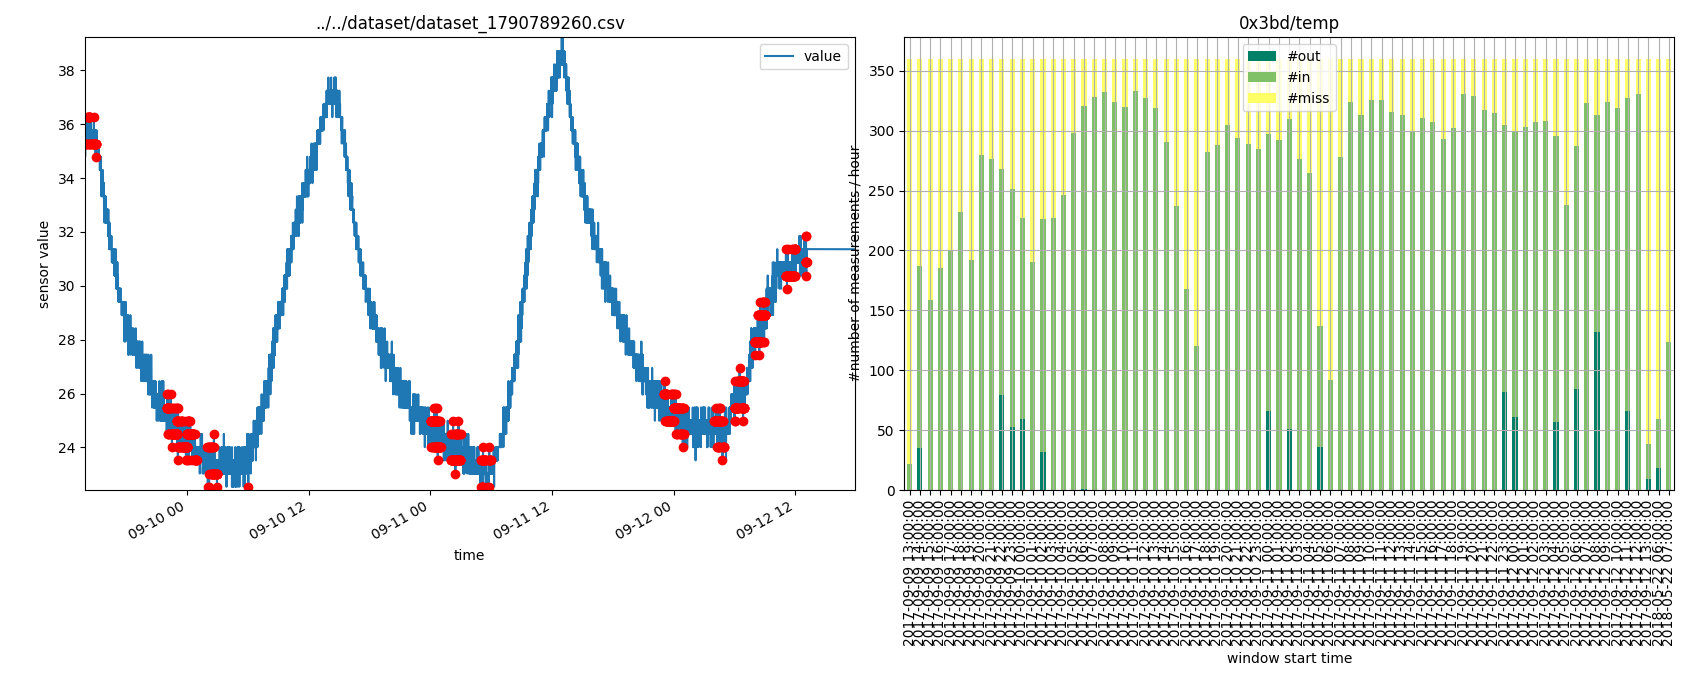

<IPython.core.display.Javascript object>


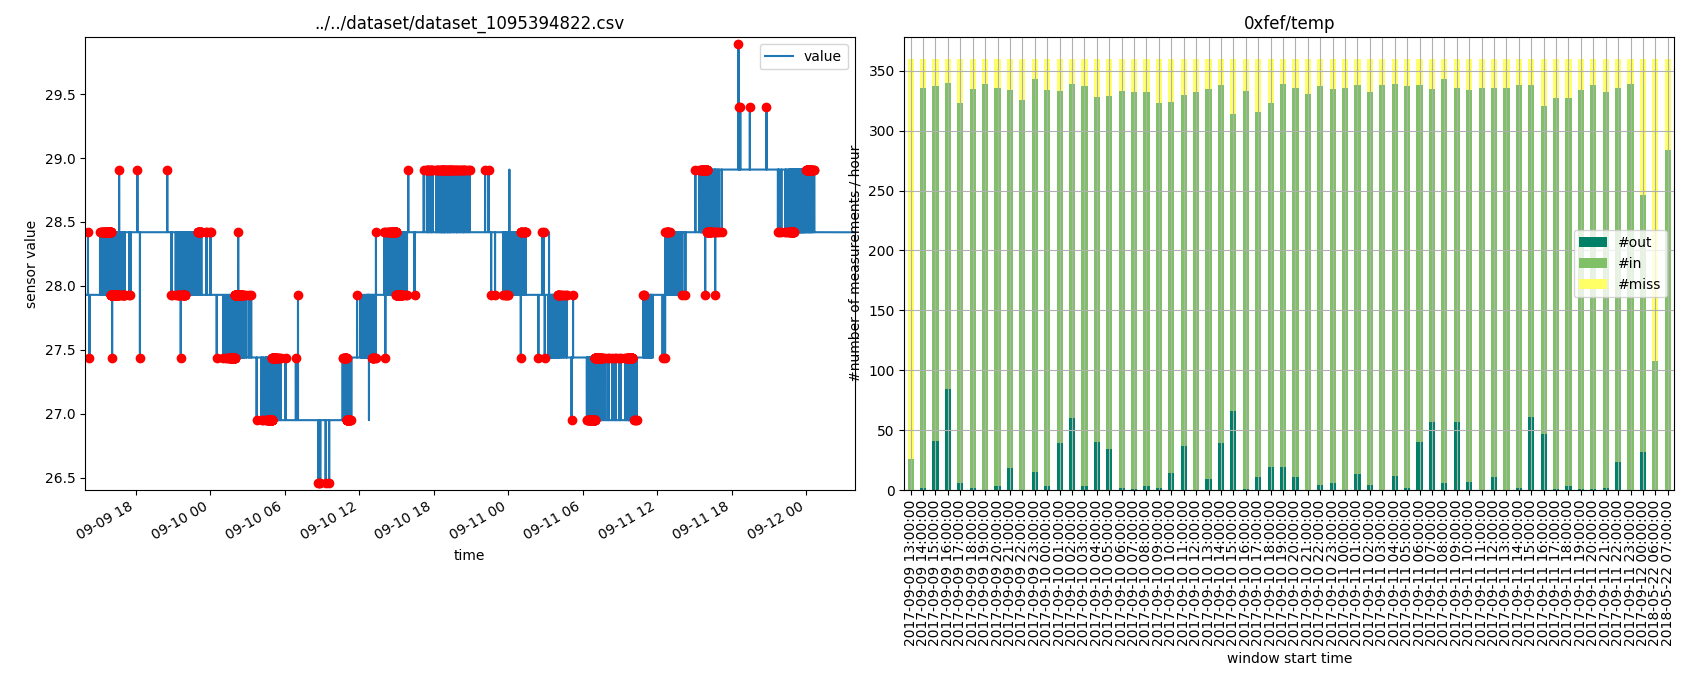

<IPython.core.display.Javascript object>


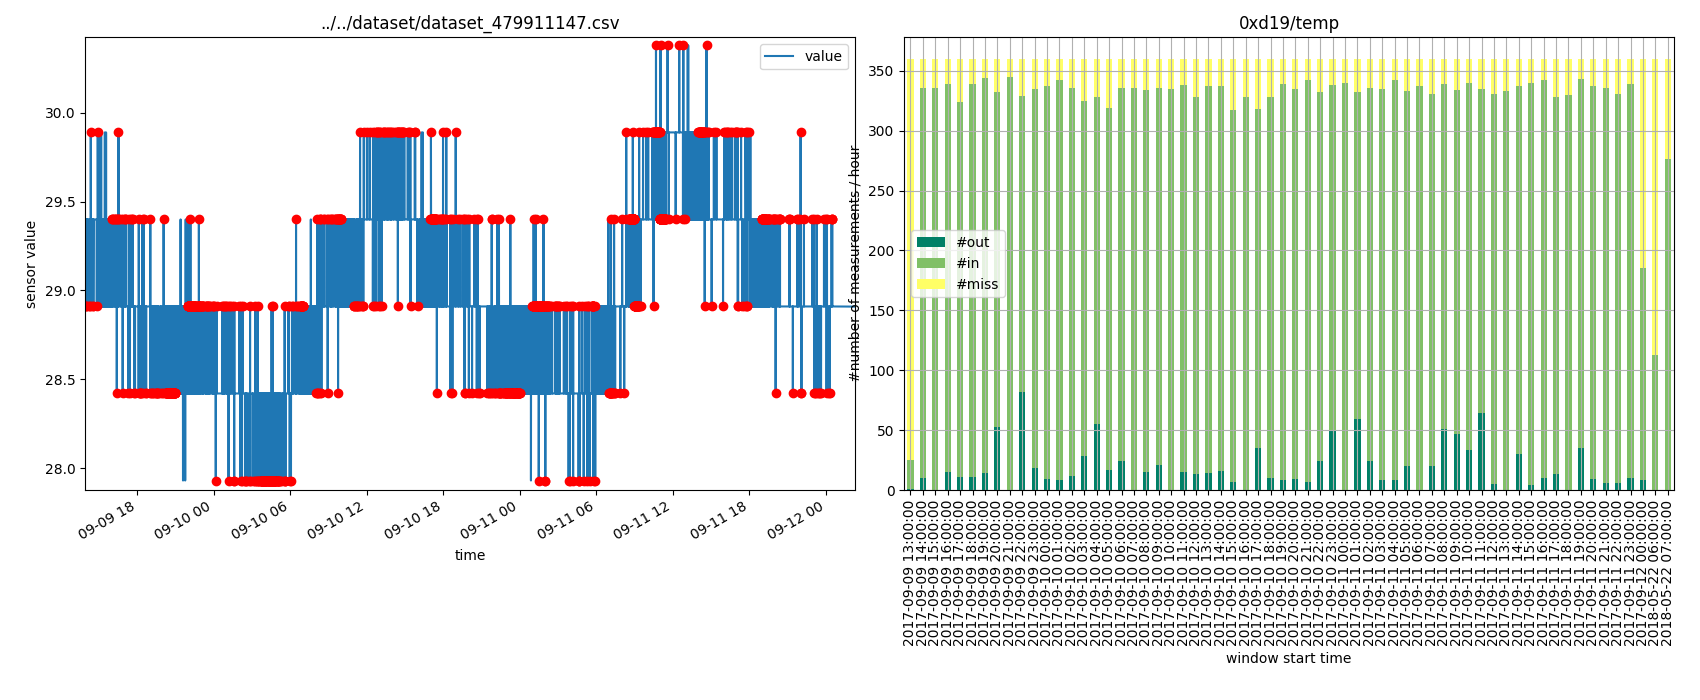

<IPython.core.display.Javascript object>


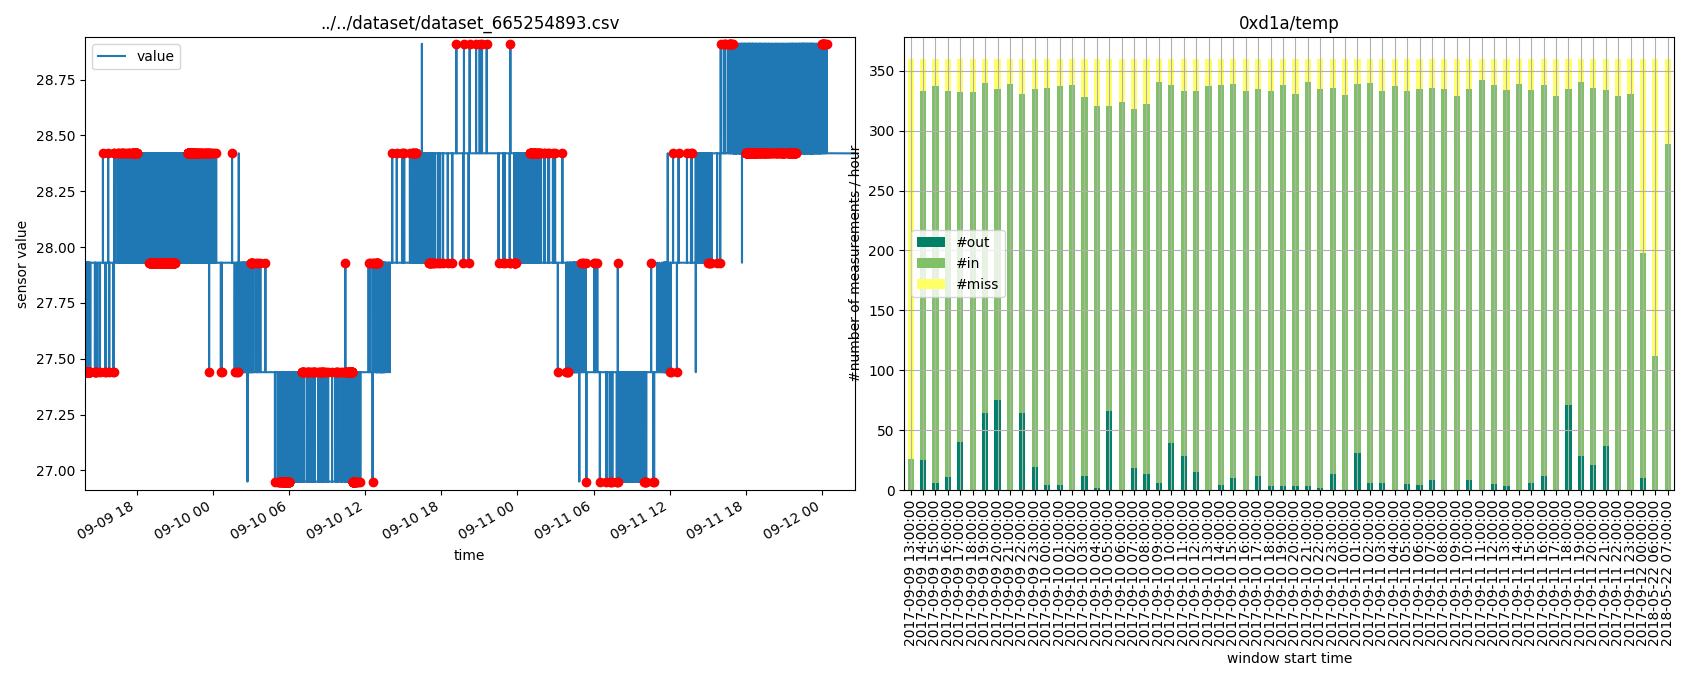

In [10]:
to_plot = t_path
for p in to_plot:
    name, num_missed, num_out, num_in = gen_plots(root, out_root, p)
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

The temperatures plot show all a similar behavior, in fact the shape will change accordingly with the hour fo the day. Will reach the bottom at the night, while will reach the top around midday.

The sensor in 0x3db is the one which see the higher variation in values, in fact we can see the difference of the temperatures within the same day are around 16 degrees.
This means that within a same time interval the temperature changes a lot, meaning that the interquartile range for each interval is wider, so the points considered as outlier are detected only when the temperature becomes stationary.

Conversely the sensors in the other nodes, see much less variation within the same day (around 2 degrees of difference from midnight and midday). The IQR is much smaller and probably will classify as outliers only the point that are farther from the mean of the values within the time window.

## Sound Plots

<IPython.core.display.Javascript object>


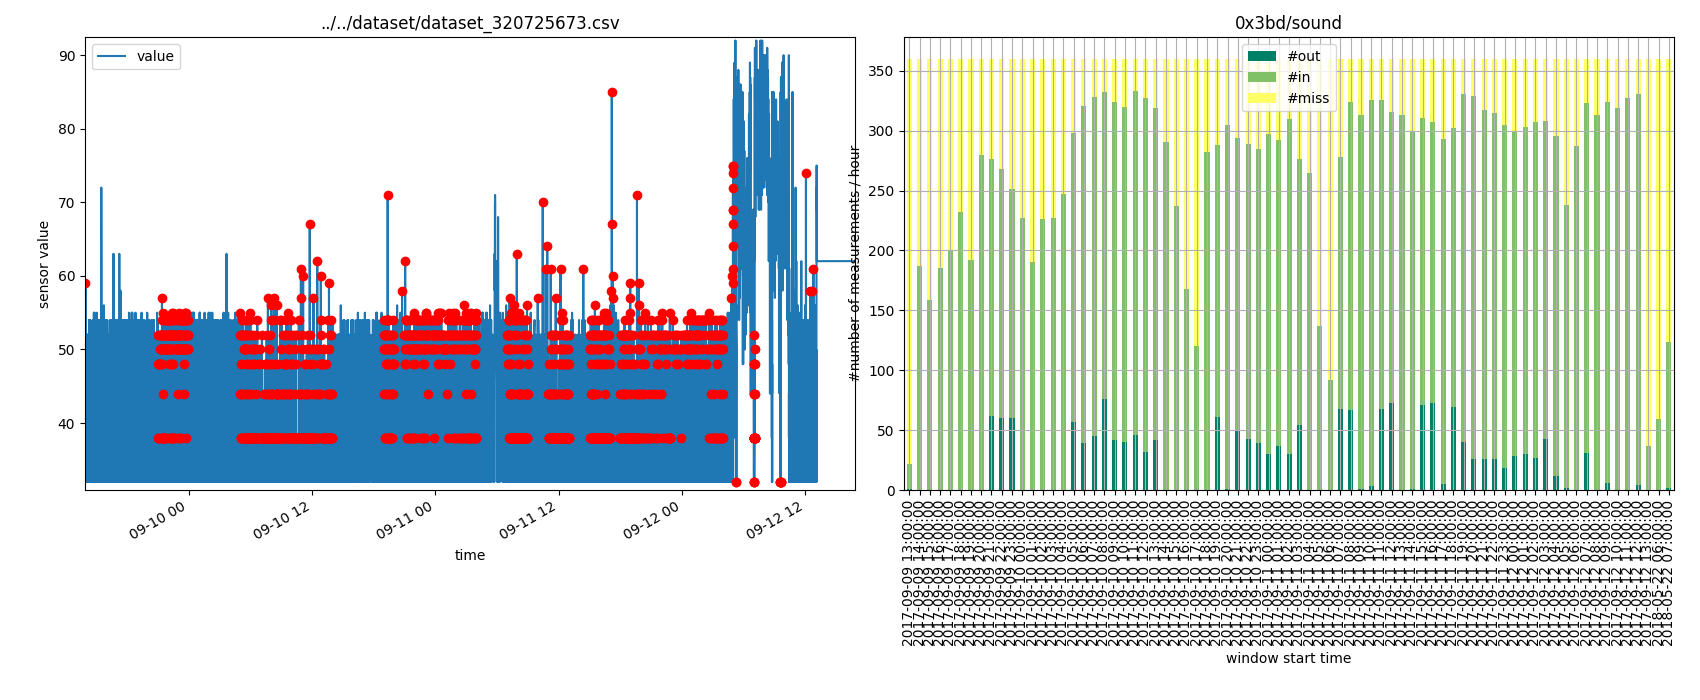

<IPython.core.display.Javascript object>


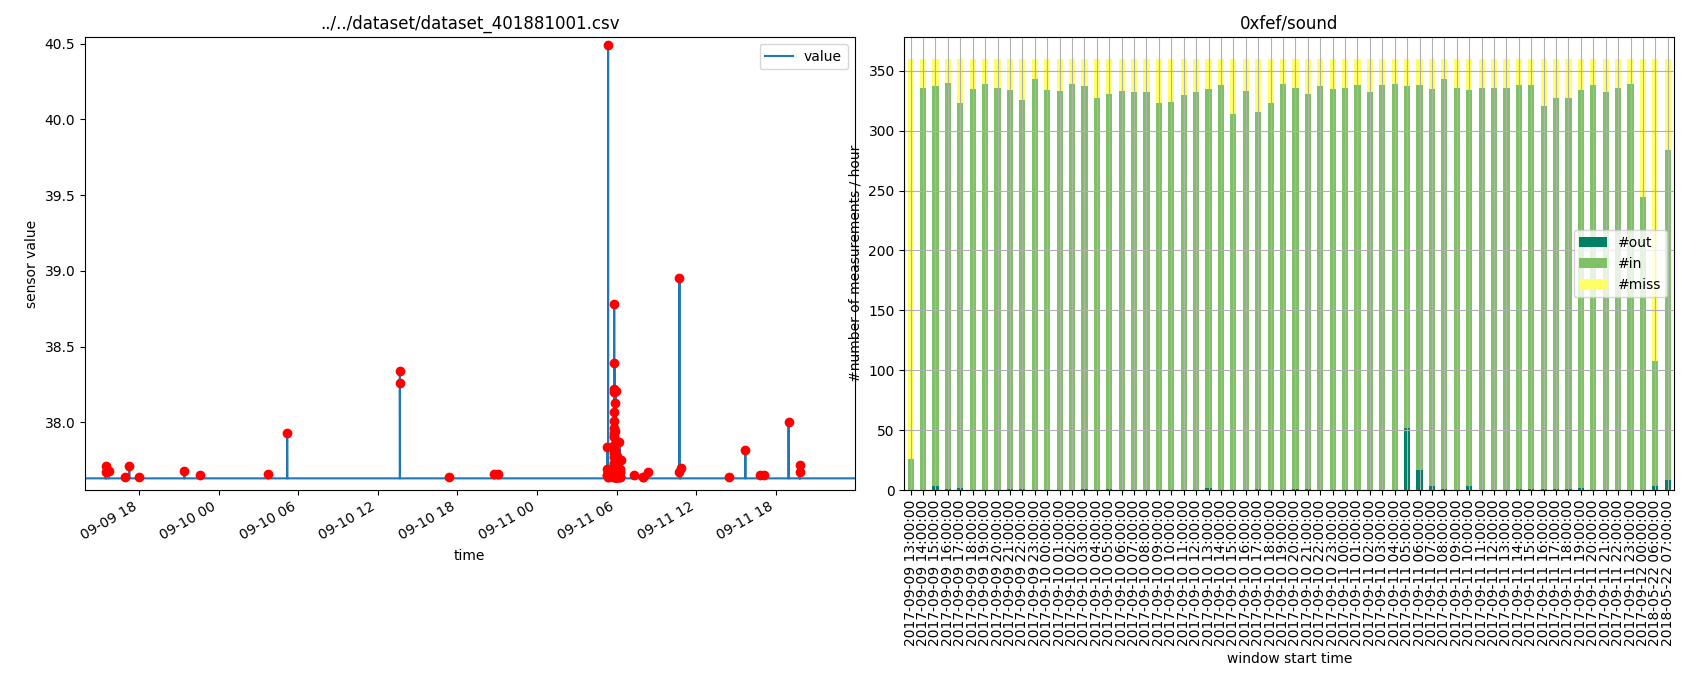

<IPython.core.display.Javascript object>


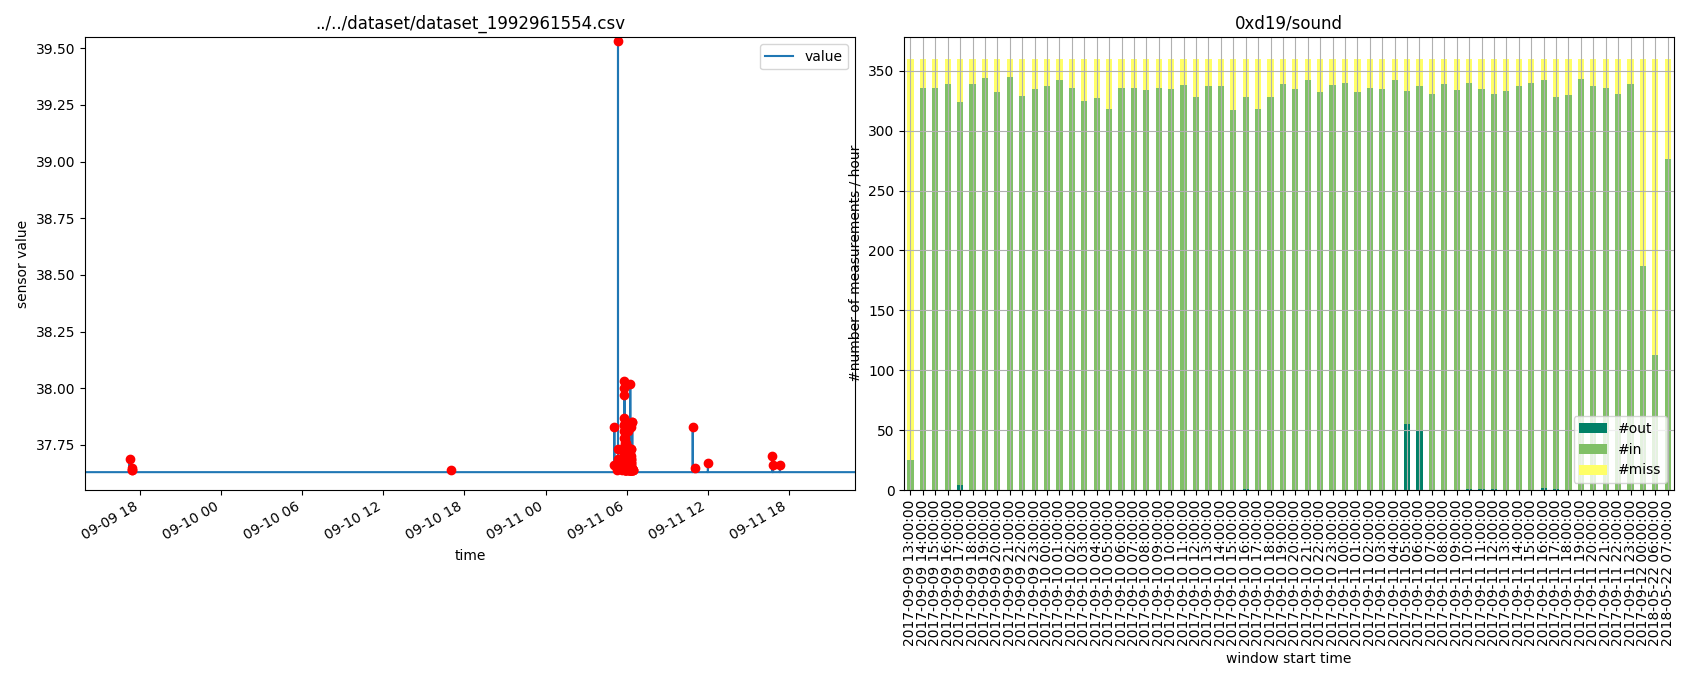

<IPython.core.display.Javascript object>


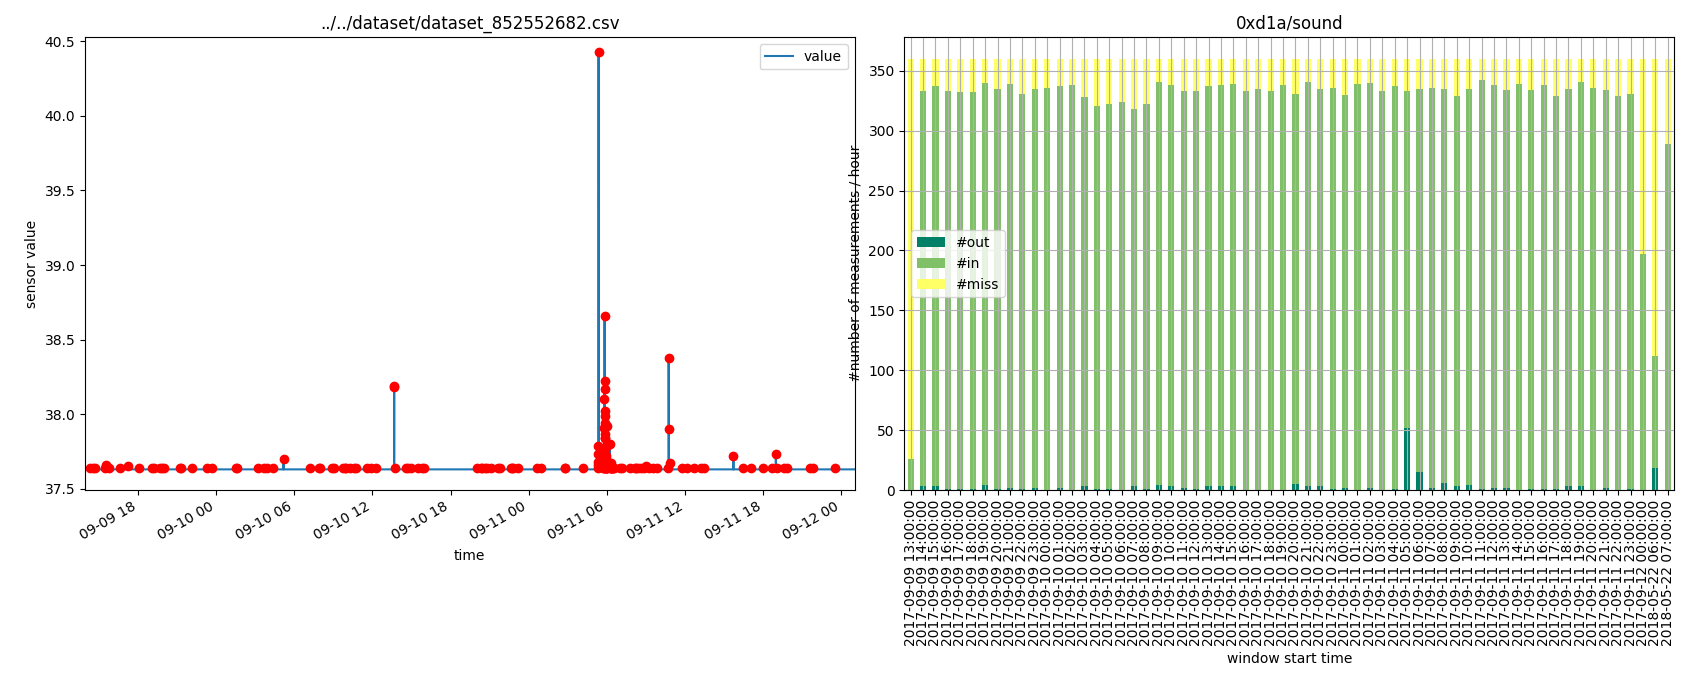

In [11]:
to_plot = s_path
for p in to_plot:
    name, num_missed, num_out, num_in = gen_plots(root, out_root, p)
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

Again, the sensor in 0x3db is the one that shows an anomaly behavior w.r.t. the other sensors. In this case it shows a lot of noise in the data, and so an higher number of outliers.
In the other cases, the sensor is mostly constant, so the minimum variation of the sensor is perceived as an outlier. 

## Light plots

<IPython.core.display.Javascript object>


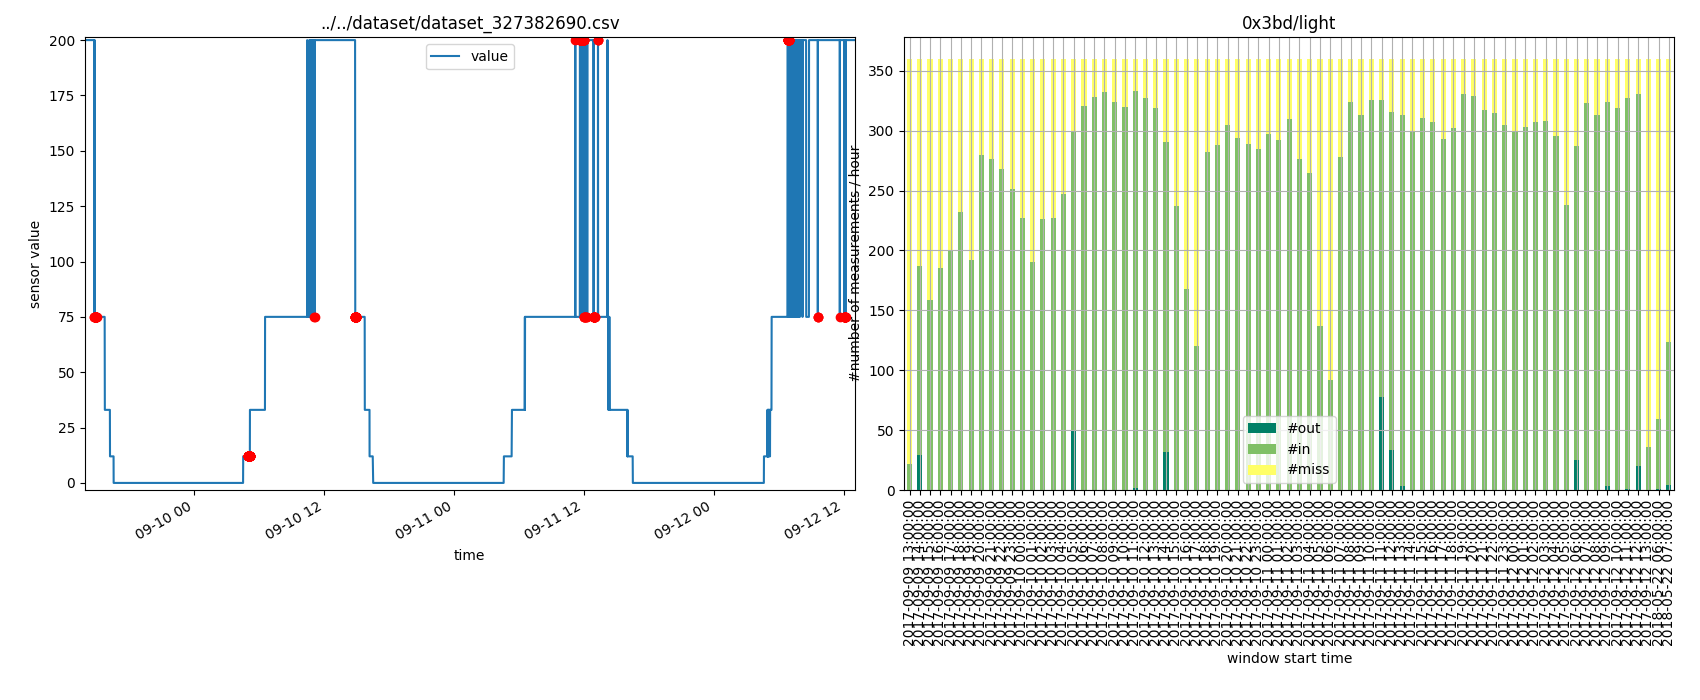

<IPython.core.display.Javascript object>


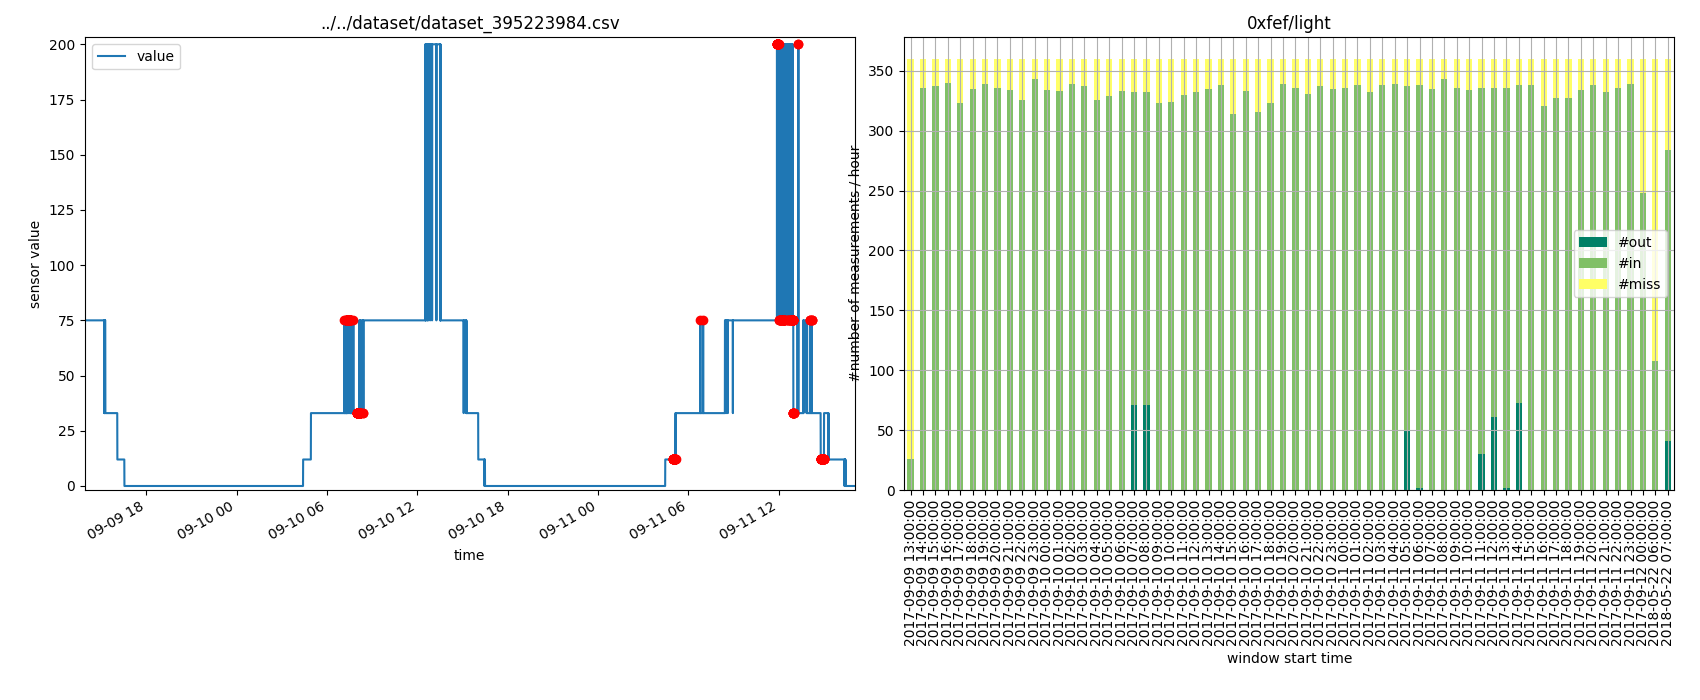

<IPython.core.display.Javascript object>


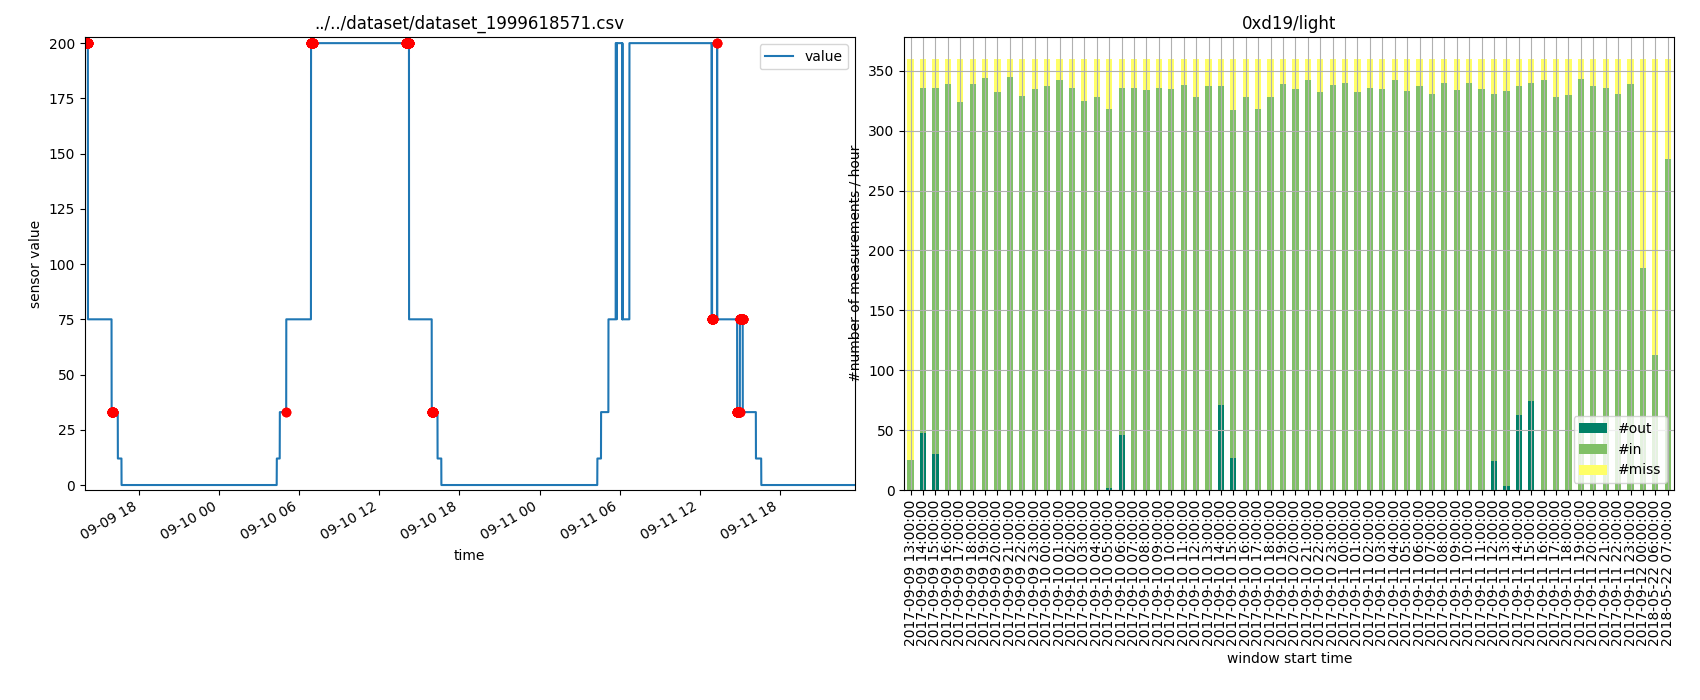

In [9]:
to_plot = l_path
for p in to_plot:
    name, num_missed, num_out, num_in = gen_plots(root, out_root, p)
    res.append("|" + str(name) + "|" + str(num_out) + "|" + str(num_in) + "|" + str(num_missed) + "|" + str(num_out*100/(num_out+num_in)) + "|")

Like the temperature sensors, the light sensor show a sort of seasonality, in fact the shape of the plot is almost identical in all the sensors independently form the node. The early morning the values increases, then get to the top value, then at the end of the day it goes down to zero. This behavior can be explained by the artificial illumination in the rooms, so the value of the light follows the times where the lights are turned on and off.

In this case only the sensors in 0xd19 shows an almost continuous shape, the outliers are mostly found in the interval where the light only increase or only decrease. 
In the other cases the measurements have a intermittent behavior and this only in few cases show an increasing number of outliers.

## Result over 1 hour aggregation

|sensor|#outliers|#inliers|#missing|%outliers|
|---|---|---|---|---|
|0x3bd/temp|921|19079|7000|4.605|
|0xfef/temp|976|19024|2320|4.88|
|0xd19/temp|1082|18918|2320|5.41|
|0xd1a/temp|825|19175|2320|4.125|
|0x3bd/sound|1766|18234|7000|8.83|
|0xfef/sound|109|19891|2320|0.545|
|0xd19/sound|115|19885|2320|0.575|
|0xd1a/sound|183|19817|2320|0.915|
|0x3bd/light|281|19719|7000|1.405|
|0xfef/light|400|19600|2320|2.0|
|0xd19/light|388|19612|2320|1.94|


The number of outliers counted within the time windows is really low w.r.t the amount of measurements.
In the case of sensors showing noisy behavior or a lot of missing values the percentage of outlier is much higher. One question arises - how much this is connected to missing values.
The plot on the left can answer, since the most of the outliers are found when the number of measurements in the time window is higher. Furthermore in the case the measurements are poor, the number of outliers are mostly 0. 